In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

In [24]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [25]:
import pandas as pd
import numpy as np

import common

In [26]:
data_set_path = "../temp_sets_100/"

# labevents

## Read samples

In [27]:
labevents_df = common.read_csv_no_rowid(data_set_path + "labevents.csv")
labevents_df = labevents_df.sample(n=2000)

## Data preproces

In [28]:
# Drop useless colums
labevents_df.drop(['subject_id', 'valuenum', 'flag'], axis=1, inplace=True)

### Process missing values

In [29]:
# Drop some null value
labevents_df.dropna(subset=['hadm_id'], inplace=True, axis=0)
labevents_df['hadm_id'] = labevents_df['hadm_id'].astype(np.int64)

In [30]:
common.nan_count(labevents_df)

Total columns: 5
Total rows: 1724
--------------
hadm_id        0
itemid         0
charttime      0
value          0
valueuom     230
dtype: int64


In [31]:
labevents_df['value'].fillna(value='Na', inplace=True)

### Set the column types

In [32]:
labevents_df.dtypes

hadm_id       int64
itemid        int64
charttime    object
value        object
valueuom     object
dtype: object

In [33]:
labevents_df['charttime'] = pd.to_datetime(labevents_df['charttime'])

In [34]:
labevents_df.dtypes

hadm_id               int64
itemid                int64
charttime    datetime64[ns]
value                object
valueuom             object
dtype: object

### Process time value

In [35]:
admissions_df = common.read_csv_no_rowid(data_set_path+"admissions.csv")

In [36]:
hadm_intime_df = admissions_df.loc[:, ['hadm_id', 'admittime']]
hadm_intime_df['admittime'] = pd.to_datetime(hadm_intime_df['admittime'])

In [37]:
labevents_mid_df = pd.merge(left=labevents_df, right=hadm_intime_df, how='left', on=['hadm_id'])

In [38]:
labevents_mid_df.dtypes

hadm_id               int64
itemid                int64
charttime    datetime64[ns]
value                object
valueuom             object
admittime    datetime64[ns]
dtype: object

In [39]:
labevents_mid_df['charttime'] = labevents_mid_df.apply(common.time_process, args=('admittime', 'charttime'), axis=1)
labevents_mid_df['charttime'] = labevents_mid_df['charttime'].astype(np.int64)

In [40]:
labevents_df = labevents_mid_df.drop(['hadm_id', 'admittime'], axis=1)

In [41]:
labevents_df.columns

Index(['itemid', 'charttime', 'value', 'valueuom'], dtype='object')

---

##  Build Network

In [42]:
from sdv.constraints import FixedCombinations

fixed_item_value_constraint = FixedCombinations(
    column_names=['itemid', 'value', 'valueuom']
)

In [43]:
constraints = [fixed_item_value_constraint]

In [44]:
train_data = labevents_df
best_model = common.build_model(constraints=constraints, train_data=train_data)

Strat training ...
Tabular Preset


Sampling rows: 100%|██████████| 1724/1724 [00:00<00:00, 52656.73it/s]


Gaussian Copula


Sampling rows: 100%|██████████| 1724/1724 [00:00<00:00, 53712.81it/s]


CTGAN


Sampling rows: 100%|██████████| 1724/1724 [00:00<00:00, 20406.21it/s]


CopulaGAN


Sampling rows: 100%|██████████| 1724/1724 [00:00<00:00, 32061.17it/s]


TVAE


Sampling rows: 100%|██████████| 1724/1724 [00:00<00:00, 27694.72it/s]


Training finished!
Strat evaluating ...
Evaluating finished!
CTGAN


Sampling rows: 100%|██████████| 1724/1724 [00:00<00:00, 17146.60it/s]


The ContinuousKL_score is: 0.9019338864783512
The DiscreteKL_score is: 0.759562149969179
The total score is: 0.8160213407853519


In [45]:
model_save_path = data_set_path + "100_models/" + "labevents_model.pkl"
common.save_model(best_model, model_save_path)

---

## Evaluate data

### Generate synthetic data

In [46]:
# Load model
date_load_path = data_set_path + "100_models/" + "labevents_model.pkl"
model = common.load_model(date_load_path)

In [47]:
sample = model.sample(num_rows=len(train_data))

Sampling rows: 100%|██████████| 1724/1724 [00:00<00:00, 8830.90it/s]


In [48]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

In [49]:
def format_values(df):
    if is_number(df['value']):
        return round(float(df['value']), 2)
    else:
        return df['value']

In [50]:
sample['value'] = sample.apply(format_values, axis=1)
sample['value'] = sample['value'].astype(str)

### Evaluation

In [51]:
from sdv.evaluation import evaluate

In [52]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.890592567565981

In [53]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.142735720992032

In [54]:
evaluate(sample, train_data)

0.574857351548312

<AxesSubplot:>

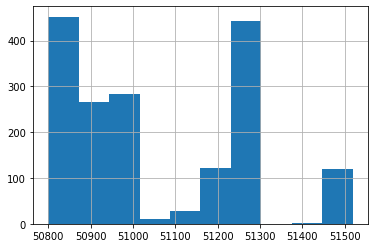

In [55]:
sample.sort_values('itemid')['itemid'].hist()

<AxesSubplot:>

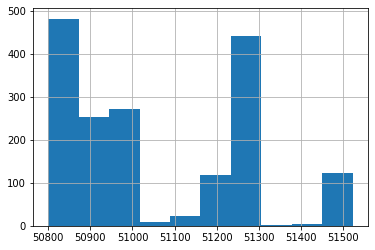

In [56]:
train_data.sort_values('itemid')['itemid'].hist()